Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 111s 233ms/step - loss: 0.1249 - val_loss: 0.1150
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 139s 227ms/step - loss: 0.1128 - val_loss: 0.1143
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 108s 230ms/step - loss: 0.1120 - val_loss: 0.1141
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 229ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 228ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 229ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 108s 229ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 228ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 229ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 227ms/step - loss: 0.1121 - val_loss: 0.1140
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


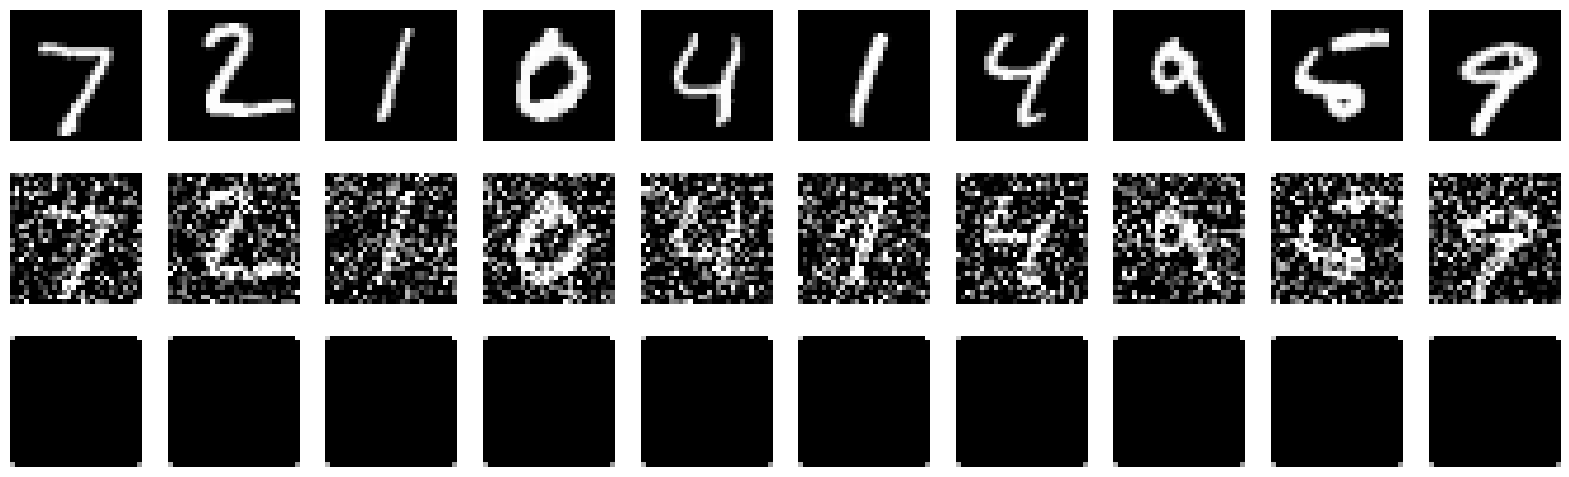

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load tensorflow dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Add Gaussian noise
def add_noise(images):
    noise_factor = 0.5
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy_images, 0.0, 1.0)

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

# Define the autoencoder
def build_autoencoder():
    input_img = tf.keras.Input(shape=(28, 28, 1))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same",
                      kernel_regularizer=regularizers.l2(1e-5))(input_img)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(16, (3, 3), activation="relu", padding="same",
                      kernel_regularizer=regularizers.l1(1e-5))(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)

    # Latent space
    encoded = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(x)

    # Decoder
    x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

    return models.Model(input_img, decoded)

# Compile the model
autoencoder = build_autoencoder()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse")

# Add Dropout and Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Train the autoencoder
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stopping]
)

# Evaluate the model
decoded_imgs = autoencoder.predict(x_test_noisy)

# Visualize results
def display_images(original, noisy, decoded, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original[i].squeeze(), cmap="gray")
        plt.axis("off")
        # Noisy
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i].squeeze(), cmap="gray")
        plt.axis("off")
        # Decoded
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(decoded[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

display_images(x_test, x_test_noisy, decoded_imgs)
